# Postprocess results from Earth Engine

Author: Frederik Kratzert
Contact: kratzert@google.com

This notebook is part of the [Caravan publication](https://eartharxiv.org/repository/view/3345/) and is the second of two notebooks that can be used to extend the dataset to new basins. This notebook is expected to be run locally (or on your own server infrastructure) and requires the outputs of the first notebook (the downloaded data from Earth Engine). 

## What is Caravan?

Caravan is ...
- an open source, large-sample rainfall-runoff dataset.
- derived entirely in the cloud (Earth Engine).
- a dataset that only uses globally available data products (namely [ECMWF's ERA5-Land](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview) and [HydroATLAS](https://www.hydrosheds.org/page/hydroatlas) by Linke et al.).

Why?
- to democratize large-sample hydrology: Anyone can extend the dataset to new regions without downloading and preprocessing large amounts of raw data. Instead, we use freely available cloud resources to do all heavy lifting in the cloud and only download the processed results.
- to advance research on global rainfall-runoff models: So far, we have seen  different large-sample datasets (e.g. CAMELS variants) that are specific to individual countries. However, due to the use of data products with only local coverage (e.g. meteorological forcing data or static attribute maps), intercomparisons betweens these products are not straight forward.

## Requirements

- Python environment with Python >= 3.6 and the following libraries installed:
  - Jupyter
  - netCDF4
  - Numba
  - Pandas
  - tqdm
  - xarray
  - timzonefinder
  
  Check the [Github repository](https://github.com/kratzert/Caravan) for an [environment.yml](https://github.com/kratzert/Caravan/environments/environment.yml) (for conda environments) or [requirements.txt](https://github.com/kratzert/Caravan/environments/requirements.txt) (pip) file.
- Outputs of the [first notebook](https://github.com/kratzert/Caravan/code/Caravan_part1_Earth_Engine.ipynb), namely the data processed by Earth Engine(ERA5 Land time series and HydroATLAS attributes).
- The latitude and longitude information for each gauge.
- Daily streamflow observations for each gauge.

## Making new data available to the community

We envision Caravan as a dynamically growing dataset that can be extended by its users. While making a large-sample dataset available upon the intial publication, the distribution of the basins is still limited to a few regions in the world. Ideally, this will change over time. Anyone who uses Caravan and this code to extend the dataset is invited to also share the streamflow time series data with the community, even if it is just for a single (or a few) basins. By doing so, little by little, we could create a new, globally spanning open source dataset that anyone can use for their own work/research. For the moment, the [discussion forum](https://github.com/kratzert/Caravan/discussions) on the Github repository is the place to share information on data that you want to contribute. See also the [wiki](https://github.com/kratzert/Caravan/wiki) on Github for further information.

## Structure of this notebook

The code consists of different sections.

1. General setup/imports/configurations
2. Processing of the raw ERA5 Land time series outputs (hourly) from Earth Engine into daily aggregates in local time (of each gauge)
3. Merging forcings with streamflow data
4. Updating attributes to include latitude/longitude 
5. Saving processed data to disk

## Citation

If you use the Caravan dataset or this code, please consider referencing the original publication

```bib
@article{kratzert2023caravan,
  title={Caravan-A global community dataset for large-sample hydrology},
  author={Kratzert, Frederik and Nearing, Grey and Addor, Nans and Erickson, Tyler and Gauch, Martin and Gilon, Oren and Gudmundsson, Lukas and Hassidim, Avinatan and Klotz, Daniel and Nevo, Sella and others},
  journal={Scientific Data},
  volume={10},
  number={1},
  pages={61},
  year={2023},
  publisher={Nature Publishing Group UK London}
}
```



# Import modules

In [27]:
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import xarray
from timezonefinder import TimezoneFinder
from tqdm.notebook import tqdm

import caravan_utils
import pet
import os 

# General configuration

Make sure to edit the fields that are listed as mandatory for the rest of this notebook to work. All `*_FILE` and `_DIR` variables should be `Path()` objects.

- `BASIN_ID_FIELD`: Name of the attribute field in the shapefile that contains the basin id.

- `BASIN_PREFIX`: A short descriptive string that is prepended to each basin id and that should be unique within the Caravan data space. E.g., we use `us` for basins from the CAMELS US dataset and `gb` for basins within Great Britain. The final name for each basin within the attribute table will be `{BASIN_PREFIX}_{GAUGE_ID}`. Note, if you already included such a prefix in the basin id field of your shapefile, leave this field as an empty string. Please also read the README in the Caravan dataset folder on details about the folder structure of the dataset.
- `ATTRIBUTE_FILE`: `Path` object pointing to a csv file with the HydroATLAS attributes as saved by Earth Engine (first notebook).
- `ERA5L_DIR`: `Path` object pointing to the directory that contains the csv files (`batchXX.csv`) with the ERA5-Land data as saved by Earth Engine (first notebook).
- `NUM_POOL_WORKERS`: Number of parallel threads that are used for some processing steps. Should not be larger than the number of CPU kernels of your machine (potentially one less than that to have some free resources while the data is processed).
- `ERA5L_BANDS`: The list of features from ERA5-Land that you want to process. Change this in case you only downloaded a subset of the bands that are the defaults in the first notebook. However, note that if you change this, you might need to adapt some parts of the code, as e.g. the climate attributes that are computed in this notebook specifically require some of the ERA5-Land bands to be present.
- `MEAN_VARS`: List of features which are aggregated to daily resolution by computing the daily mean. Change this in case you only downloaded a subset of the bands that are the defaults in the first notebook.
- `MIN_VARS`: Same as above, but instead of aggregating by computing the mean, the min value is used.
- `MAX_VARS`: Same as above, but instead of aggregating by computing the mean, the max value is used.
- `SUM_VARS`: Same as above, but instead of aggregating by computing the mean, the daily sum value is used.

In [28]:
# Define file paths
cwd = Path(os.getcwd())

# ------------------------------ Mandatory ------------------------------------#

BASIN_ID_FIELD = 'gauge_id'
BASIN_PREFIX = 'vlaamsebekken'
ATTRIBUTE_FILE = cwd / "my_caravan_bellebeek" / "attributes" / "attributes.csv"
ERA5L_DIR = cwd / "my_caravan_bellebeek"
OUTPUT_DIR = cwd / "output_caravan_bellebeek"

# ------------------------------ Optional -------------------------------------#
NUM_POOL_WORKERS = 8
ERA5L_BANDS = [
    'temperature_2m',
    'dewpoint_temperature_2m',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    'volumetric_soil_water_layer_3',
    'volumetric_soil_water_layer_4',
    'surface_net_solar_radiation',
    'surface_net_thermal_radiation',
    'u_component_of_wind_10m',
    'v_component_of_wind_10m',
    'surface_pressure',
    'total_precipitation',
    'snow_depth_water_equivalent',
    'potential_evaporation',
]
MEAN_VARS = [
    'snow_depth_water_equivalent',
    'surface_net_solar_radiation',
    'surface_net_thermal_radiation',
    'surface_pressure',
    'temperature_2m',
    'dewpoint_temperature_2m',
    'u_component_of_wind_10m',
    'v_component_of_wind_10m',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    'volumetric_soil_water_layer_3',
    'volumetric_soil_water_layer_4',
]
MIN_VARS = MEAN_VARS
MAX_VARS = MEAN_VARS
SUM_VARS = ['total_precipitation', 'potential_evaporation']

if not all([isinstance(x, Path) for x in [ATTRIBUTE_FILE, ERA5L_DIR, OUTPUT_DIR]]):
    raise ValueError("All paths to directories or files need to be Path objects.")

# Load and unify raw Earth Engine outputs

The purpose of this first part is to postprocess the raw outputs from Earth Engine into per-basin time series. Since the hourly data for multiple (hundreds) of basins can become quite large, this part of the code does the following.

1. We read the Earth Engine outputs (the batch files) file by file. Each file contains data for a specific time period for all basins.
2. We split this data by basins and store them temporary to per-basin csv files for each of the batch files.
3. After all batch files are processed, we iterate over the basins and combine the temporary per-basin files (of each batch) into one single file with all data.

This part of the code can become quite compute intensive, especially for a large number of basins, e.g. several hundreds. To make things faster, we offer a parallized implementation of the steps above. However, sometimes the multiprocessing library fails to process the data (or runs indefinitely without any progress), for no apparent reason. If this is happening to you, you can run the sequential processing code blow. 

All intermediate temporary files are deleted after this process and the combined hourly per-basin files are also deleted at the end of this notebook.

## Parallelized implementation

Make sure to adapt the `NUM_POOL_WORKERS` according to your system. If you noticed that nothing happens, e.g. the progress bar does not advance after a while or you see no temporary files being created at the `OUTPUT_DIR`, stop this code block and execute the (slower) sequential code below.

In [29]:
finished_preprocessing = False
csv_files = sorted(list((ERA5L_DIR).glob('batch*.csv')))
caravan_utils.process_earth_engine_outputs(csv_files=csv_files,
                                           basin_id_field=BASIN_ID_FIELD,
                                           era5l_bands=ERA5L_BANDS,
                                           output_dir=OUTPUT_DIR,
                                           num_workers=NUM_POOL_WORKERS)
print(f"Temporary data stored at {OUTPUT_DIR / 'temp'}. Will be removed at the end of this notebook.")
basins = [p.name for p in (OUTPUT_DIR / "temp").glob('*')]
finished_preprocessing = True

Splitting Earth Engine output into per-basin files.:   0%|          | 0/51 [00:00<?, ?it/s]

Combining files per-basin into one file.:   0%|          | 0/1 [00:00<?, ?it/s]

Temporary data stored at e:\Users\ddknop\thesis_order\2_River_to_Caravan\output_caravan_bellebeek\temp. Will be removed at the end of this notebook.


# Load gauge lat/lon info

**USER INPUT REQUIRED**

Here, you need to add code to load gauge latitude and longitude information. This is required to be able to convert the ERA5-Land time series from UTC to local time, before calculating daily statistics and finally merging it with daily streamflow data. Additionally, it would be amazing to add the name of the gauge station as well as the name of the country to this dataframe.

You need to do the following:
- Load latitude, longitude (of the gauge station), name (of the gauge station) and the country name(s) from any source.
- Create a pandas DataFrame, called `df_metadata` that is indexed by the basin id (same id's as in the Earth Engine outputs) with the following columns:

  - `gauge_lat` contains the latitude values (in WGS84).
  - `gauge_lon` contains the longitude values (in WGS84).
  - `gauge_name` contains the name of the gauge stations. If not available, it can be an empty string. But better would be to provide e.g. the closest village/city or the name of the river.
  - `country` the name of the country.

In [30]:


# Load your lat/lon information here
data = {
    'gauge_lat': [50.88874727343258],  # Wrap the value in a list
    'gauge_lon': [4.116261134168794],  # Wrap the value in a list
    'gauge_name': ['Essene/Bellebeek'],  # Wrap the value in a list
    'country': ['Belgium']  # Wrap the value in a list
}

# Create a DataFrame from the dictionary
df_metadata = pd.DataFrame(data)

# Set the index to the basin ID 
df_metadata.index = ['7']

# Display the DataFrame
print(df_metadata)
print(df_metadata.index)

   gauge_lat  gauge_lon        gauge_name  country
7  50.888747   4.116261  Essene/Bellebeek  Belgium
Index(['7'], dtype='object')


## Validate loaded lat/lon data

Execute this code section to test the validity of your `df_lat_lon` DataFrame.

In [31]:
if not 'df_metadata' in locals():
    raise RuntimeError("A variable 'df_metadata' does not exist")

if not isinstance(df_metadata, pd.DataFrame):
    raise RuntimeError("'df_metadata' is not a pandas DataFrame")

missing_basins = [x for x in basins if x not in df_metadata.index]
if missing_basins:
    raise RuntimeError("The following basins are missing in the index of the "
                       f"DataFrame: {missing_basins}")

if any([x not in df_metadata.columns for x in ['gauge_lat', 'gauge_lon', 'country', 'gauge_name']]):
    raise RuntimeError("Missing one (or more) of the following columns: "
                       "'gauge_lat', 'gauge_lon', 'country', 'gauge_name'")

if df_metadata[['gauge_lat', 'gauge_lon', 'gauge_name', 'country']].isnull().values.any():
    raise RuntimeError("There is at least one NaN value in the dataframe")

# Make sure the index is called "gauge_id"
df_metadata.index.name = "gauge_id"

print("All tests passed successfully.")

All tests passed successfully.


## Aggregate to daily resolution

To be able to convert the hourly ERA5-Land data to daily aggregates we need to execute the following steps.

1. Disaggregate ERA5-Land features that are provided as accumulates over the day (see explanation below).
2. Convert ERA5-Land variables to units more common for hydrological applications.
3. Shift to local time and aggregate to daily resolution (see explanation below).

### Disaggregate ERA5Land features and convert units

Some ERA5-Land features accumulate their values over one day (in UTC). Meaning that, e.g., the precipitation value at `01:00` contains the total precipitation that has fallen from `00:00` to `01:00` and the value of `02:00` contains the total precipitation that has fallen from `00:00` to `02:00` (and not the amount that has fallen from `01:00` to `02:00`). Because we want to convert the hourly UTC data to local time (below), we first disaggregate the cumulated features into hourly "instantaneous" (or hourly accumulated) values. Due to some numerical issues (on Earth Engine/ERA5-Land side), there might also be some physically implausible values, e.g., instead of 0 mm precipitation there is a very tiny negative value. We clip these cases to zero. 

### Unit conversion
We convert the ERA5-Land features into units that are more common in hydrology (e.g., precipitation in mm instead of m). For details see the `era5l_unit_conversion` in `caravan_utils.py` or check the metadata that is stored in the netCDF files. 

### Aggregate to daily statistics

Special care has to be taken when computing daily aggregates from hourly values, especially with those features that are accumulates, rather than instantenous values. Of the features included in Caravan, `total_precipitation`,`potential_evaporation`, `surface_net_solar_radiation`, and `surface_net_thermal_radiation` are accumulates, while all others are instantenous values. For the accumulates, according to the [ERA5Land documentation](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-accumulationsAccumulations), the value that is stored at e.g. 1981-01-01 00:00 is the value that is accumulated over the previous hour _up to_ 00:00. This means that this value should not be included when computing the daily statistics for 1981-01-01. The 24 data points that should be included to compute e.g. the daily statistics for 1981-01-01 are from 1981-01-01 01:00 until (including) 1981-01-02 00:00. We need to consider this when we use the resampling function of the pandas library, which does (by defaul) resample by date, which would be wrong in this case. We can mitigate that by passing an `offset=pd.Timedelta(hours=-1)` to the resample function. For the instantenous values it doesn't really make a difference if the steps 00:00 to 23:00 are used, or also the values 01:00 to 00:00 (==24:00). Therefore, we chose to take the same timesteps as for the accumulates.

In [32]:
daily_dfs = {}

for basin in tqdm(basins):
    netcdf_file = OUTPUT_DIR / "temp" / basin / "combined.nc"
    if not netcdf_file.is_file():
        print(f"Combined netCDF file does not exist at {netcdf_file}"
              " Make sure to succesfully execute the blocks above")
    df = xarray.open_dataset(netcdf_file).to_dataframe()
    # By ERA5-Land conventions, PET, as an upward flux, has a negative sign.
    # We change this to a positive sign, which is more common for hydrological applications.
    df["potential_evaporation"] = df["potential_evaporation"] * -1

    # Disaggregate features that are accumulated over the day into hourly values.
    df = caravan_utils.disaggregate_features(df)

    # Clip precipitation and SWE to 0. They can have small negative values due to numerical issues.
    df.loc[df["total_precipitation"] < 0, "total_precipitation"] = 0.0
    df.loc[df["snow_depth_water_equivalent"] < 0, "snow_depth_water_equivalent"] = 0.0

    # Convert ERA5-Land variables into units that are more common for hydrological applications.
    df = caravan_utils.era5l_unit_conversion(df)

    # Aggregate dataframe to daily resolution in local time
    df_daily = caravan_utils.aggregate_df_to_daily(df=df,
                                                   gauge_lat=df_metadata.loc[df_metadata.index == basin,
                                                                             'gauge_lat'].values[0],
                                                   gauge_lon=df_metadata.loc[df_metadata.index == basin,
                                                                             'gauge_lon'].values[0],
                                                   mean_vars=MEAN_VARS,
                                                   min_vars=MIN_VARS,
                                                   max_vars=MAX_VARS,
                                                   sum_vars=SUM_VARS)

    # Add FAO Penman-Monteith time series and rename ERA5-Land PET.
    df_daily["potential_evaporation_sum_FAO_PENMAN_MONTEITH"] = pet.get_fao_pm_pet(
        surface_pressure_mean=df_daily["surface_pressure_mean"],
        temperature_2m_mean=df_daily["temperature_2m_mean"],
        dewpoint_temperature_2m_mean=df_daily["dewpoint_temperature_2m_mean"],
        u_component_of_wind_10m_mean=df_daily["u_component_of_wind_10m_mean"],
        v_component_of_wind_10m_mean=df_daily["v_component_of_wind_10m_mean"],
        surface_net_solar_radiation_mean=df_daily["surface_net_solar_radiation_mean"],
        surface_net_thermal_radiation_mean=df_daily["surface_net_thermal_radiation_mean"])
    df_daily.rename(columns={'potential_evaporation_sum': 'potential_evaporation_sum_ERA5_LAND'}, inplace=True)

    daily_dfs[basin] = df_daily

  0%|          | 0/1 [00:00<?, ?it/s]

# Load streamflow data

**USER INPUT REQUIRED**

Here, you need to add code to load area-normalized daily streamflow data (**unit: mm/d**) that will be merged with the time series from ERA5-Land.

You need to do the following:
- Load area-normalized streamflow data from any source and make sure it is in daily resolution. The assumption is that the data is in local time so that it matches the ERA5-Land aggregates we computed above in local time. If your streamflow data are not daily averages in local time make sure to adapt the aggregation code above.
- Create a pandas DataFrame, called `df_streamflow` that is datetime-indexed and contains one column with streamflow data per gauge/basin.
- The name of the column has to match the gauge/basin id, as in the `df_lat_lon` DataFrame and the ERA5-Land data from Earth-Engine.
- Missing values should be indicated by `NaN` (e.g. using `np.nan`) and _not_ by negative numbers.

Note: It is possible to proceed, even if you do not have streamflow data for a particular gauge. In this case, simply add a column for said basin filled with NaN values. Also note that the length of the streamflow records does not have to match the entire period of the meteorological forcings but can be less.

                      #Timestamp  Value  Quality Code  Absolute Value  \
0  1972-08-30T00:00:00.000+01:00  0,355           220             NaN   
1  1972-08-31T00:00:00.000+01:00  0,335           220             NaN   
2  1972-09-01T00:00:00.000+01:00  0,341           220             NaN   
3  1972-09-02T00:00:00.000+01:00  0,323           220             NaN   
4  1972-09-03T00:00:00.000+01:00  0,330           220             NaN   

   AV Quality Code  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
                   7
1972-08-29  0.303857
1972-08-30  0.286738
1972-08-31  0.291874
1972-09-01  0.276467
1972-09-02  0.282459
...              ...
2025-03-05  0.432248
2025-03-06  0.415985
2025-03-07  0.407425
2025-03-08  0.401434
2025-03-09  0.396298

[19186 rows x 1 columns]


<Axes: >

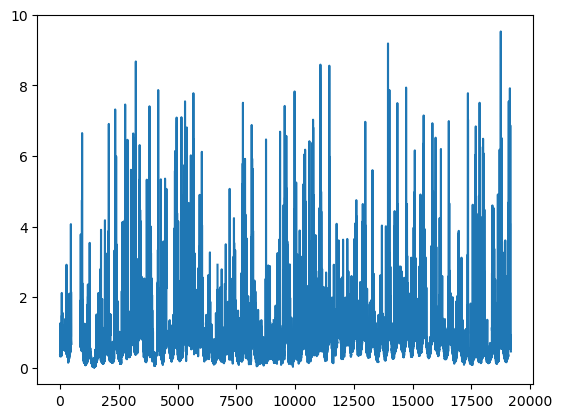

In [33]:

# Adjust the file path as necessary
file_path = cwd / 'Essene_Bellebeek_Discharge.csv'
df = pd.read_csv(file_path, 
                 sep=';',
                 skiprows=7) 

timestamp_column = df.columns[0]
value_column = df.columns[1]
print(df.head())
area = 100_942_161.19 #m²
df[timestamp_column] = pd.to_datetime(df[timestamp_column], utc = True)
df['Value'] = df['Value'].str.replace(',', '.').astype(float)
df_streamflow = df.set_index('#Timestamp')['Value'].to_frame()
df_streamflow.columns = ['7']
df_streamflow[df_streamflow < 0] = np.nan
df_streamflow.index = pd.to_datetime(df_streamflow.index, utc=True)
df_streamflow.index.name  = None

# # Verwijder timezone informatie van df_streamflow
df_streamflow.index = df_streamflow.index.tz_localize(None)
df_streamflow.index = df_streamflow.index.normalize()
df_streamflow['7'] = (df_streamflow['7']/area)*1000*3600*24
print(df_streamflow)
df["Value"].plot()

### Validate loaded streamflow data
Execute this code section to test the validity of your `df_streamflow` DataFrame.

In [34]:
if not 'df_streamflow' in locals():
    raise RuntimeError("A variable 'df_streamflow' does not exist")

if not isinstance(df_streamflow, pd.DataFrame):
    raise RuntimeError("'df_streamflow' is not a pandas DataFrame")

missing_basins = [x for x in daily_dfs.keys() if x not in df_streamflow.columns]
if missing_basins:
    raise RuntimeError("The following basins are missing in the columns of the "
                       f"DataFrame: {missing_basins}")

if not isinstance(df_streamflow.index, pd.core.indexes.datetimes.DatetimeIndex):
    raise RuntimeError("The streamflow needs to have a DatetimeIndex")

if not pd.infer_freq(df_streamflow.index) == 'D':
    raise RuntimeError("The frequency of the DatetimeIndex must be daily but "
                       "isn't or can't be inferred.")

if df_streamflow.lt(0.0).any().any():
    raise RuntimeError("DataFrame contains negative values. Make sure to mark invalid "
                       "streamflow by NaN and not by a negative constant.")
# Make sure the index is called "date"
df_streamflow.index.name = "date"

print("All tests passed successfully.")

All tests passed successfully.


# Merge streamflow and ERA5-Land time series

Finally, we can merge the streamflow data to the ERA5-Land time series. Note, even if the streamflow records exceed the length of the ERA5-Land period, we only keep the data for which ERA5-Land features exist.


In [35]:

for basin, basin_df in tqdm(daily_dfs.items()):
    start_date, end_date = basin_df.index[0], basin_df.index[-1]
    basin_df["streamflow"] = df_streamflow[basin][start_date:end_date]

  0%|          | 0/1 [00:00<?, ?it/s]

## Truncate precision of data to 2 decimal digits

The data in Caravan will be shared rounded to two decimal digits. Here, we make sure that we perform the truncation before computing the climate indicies (see box below).

In [36]:
for basin, df in tqdm(daily_dfs.items()):
    daily_dfs[basin] = df.round(2).map('{:.2f}'.format).map(float)

  0%|          | 0/1 [00:00<?, ?it/s]

## Compute climate indices

Besides the HydroATLAS attributes that are part of Caravan, we also add a couple of climate indices that are derived from the ERA5-Land time series. Most of these are the same attributes provided with the CAMELS US dataset (see [Addor et al.](https://hess.copernicus.org/articles/21/5293/2017/)). The exception are the seasonality, fraction of snow and the moisture index, which are computed following [Knoben et al.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR022913) 

In [37]:
climate_indices = {}
for basin, df in tqdm(daily_dfs.items()):
    climate_indices[basin] = caravan_utils.calculate_climate_indices(df)
df_caravan = pd.DataFrame.from_dict(climate_indices, orient='index')
df_caravan.index.name = "gauge_id"
df_caravan.head()

  0%|          | 0/1 [00:00<?, ?it/s]

,p_mean,pet_mean_ERA5_LAND,pet_mean_FAO_PM,aridity_ERA5_LAND,aridity_FAO_PM,frac_snow,moisture_index_ERA5_LAND,seasonality_ERA5_LAND,moisture_index_FAO_PM,seasonality_FAO_PM,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur
gauge_id,,,,,,,,,,,,,,
7,2.211639,3.652053,1.613523,1.651288,0.72956,0.0,-0.223706,1.159175,0.292683,1.173198,0.035661,1.099156,0.574606,3.511083


# Add area to metadata and remove from HydroATLAS attributes

The basin area is stored in the Earth Engine attribute file. We remove the column from there and drop it from the HydroATLAS attributes.

In [38]:
# Make sure we only add rows of basins for which we processed time series data
df_metadata = df_metadata.loc[basins]

# Make sure we only add the lat/lon column
drop_cols = [x for x in df_metadata.columns if x not in ['gauge_lat', 'gauge_lon', 'gauge_name', 'country']]
df_metadata = df_metadata.drop(drop_cols, axis=1)

# Add area to metadata df.
df_hydroatlas = pd.read_csv(ATTRIBUTE_FILE, index_col='gauge_id')
df_metadata['area'] = df_hydroatlas.loc[BASIN_PREFIX + "_" + "_".join(basins), 'area']
# Remove area from hydroatlas features.
df_hydroatlas = df_hydroatlas.drop(['area'], axis=1)

# Sort all DataFrames alphanumerically
df_metadata = df_metadata.sort_index(axis=0)
df_caravan= df_caravan.sort_index(axis=0)
df_hydroatlas = df_hydroatlas.sort_index(axis=0)

# Save results to disk

Having everything processed, we can finally store the results to disk to extend the Caravan dataset. The data is stored in the following structure (to mimic the fold structure of the Caravan dataset) and can be integrated as-is into the original Caravan dataset.

- `{OUTPUT_DIR}/`: The outermost folder is the user-defined `OUTPUT_DIR` (see General Configuration section). All resulting data will be stored in this folder, mimicking the folder structure of the Caravan dataset.
- `{OUTPUT_DIR}/attributes/{BASIN_PREFIX}/`: This folder will contain three files. The first is `attributes_caravan_{BASIN_PREFIX}.csv`, which contains the climate indices computed above. The second is `attributes_hydroatlas_{BASIN_PREFIX}.csv`, which contain the HydroATLAS attributes as saved by Earth Engine. The third is `attributes_other_{BASIN_PREFIX}.csv`, which contain the metadata information, such as gauge_lat, gauge_lon, gauge_name, country, and area.
- `{OUTPUT_DIR}/timeseries`: The per-basin time series data will be stored in this folder. Two options exist: as netCDF file or as csv file. For each option, a different folder is created, `{OUTPUT_DIR}/timeseries/netcdf` and `{OUTPUT_DIR}/timeseries/csv`. In each of these folders, you will find a folder similar to the user-defined `BASIN_PREFIX`. This folder finally contains one netCDF (or one csv file) per basin, called `{gauge_id}.nc` (or `{gauge_id}.csv`).

This folder/file structure can be copied directly into the original Caravan dataset (or stored separately, as you prefer).

## Save attributes

This block will create two files:

- `{OUTPUT_DIR}/attributes/{BASIN_PREFIX}/attributes_hydroatlas_{BASIN_PREFIX}.csv`: The HydroATLAS attributes as saved from Earth Engine.
- `{OUTPUT_DIR}/attributes/{BASIN_PREFIX}/attributes_caravan_{BASIN_PREFIX}.csv`: The climate indices computed in this notebook.
- `{OUTPUT_DIR}/attributes/{BASIN_PREFIX}/attributes_other_{BASIN_PREFIX}.csv`: Metadata information, such as gauge_lat, gauge_lon, gauge_name, country, and area.

In [39]:
attribute_dir = OUTPUT_DIR / "attributes" / BASIN_PREFIX
if not attribute_dir.is_dir():
    attribute_dir.mkdir(parents=True)

# Store climate attributes from DataFrame to disk.
df_metadata.to_csv(attribute_dir / f"attributes_other_{BASIN_PREFIX}.csv")
df_caravan.to_csv(attribute_dir / f"attributes_caravan_{BASIN_PREFIX}.csv")
df_hydroatlas.to_csv(attribute_dir / f"attributes_hydroatlas_{BASIN_PREFIX}.csv")


## Save as netCDF

Execute the sections below, if you want to store the data in netCDF format. Because netCDF can include metadata information, we will add some metadata before storing to disk. More specifically, we add the following information:

- `Units`: Explanation of the physical unit of each variable.
- `Timezone`: A string defining the local time zone of this gauge.
- `Sources`: A user-defined string (see below) that adds information about the source of the data. Here you can add information about the source (and license) of the streamflow data.

If you do not want to store the data in netCDF format, proceed to the section "Save as csv".

### Metadata information

Use the variable `data_sources` to add any information, e.g., about the source of the streamflow data. It is recommended to include the statement of ERA5-Land, especially if you want to share your data.

In [40]:
# Add any information that you like to this string.
data_sources = ('All forcing and state variables are derived from ERA5-Land ' 
                'hourly by ECMWF. Streamflow data ...')

if not isinstance(data_sources, str):
    raise RuntimeError("'data_sources' has to be a string.")

### Convert to xarray Dataset, add metadata, and save to disk

In [41]:
tf = TimezoneFinder()

netcdf_dir = OUTPUT_DIR / "timeseries" / "netcdf" / BASIN_PREFIX

for basin, basin_df in tqdm(daily_dfs.items()):
    xr = xarray.Dataset.from_dataframe(basin_df).astype(np.float32)

    metadata = caravan_utils.get_metadata_info(xr)
    unit_info = ""
    for k, v in metadata.items():
        unit_info = unit_info + f"{k}: {v}\n"
    xr.attrs["Units"] = unit_info

    lat = df_metadata.loc[df_metadata.index == basin, "gauge_lat"].values[0]
    lon = df_metadata.loc[df_metadata.index == basin, "gauge_lon"].values[0]
    xr.attrs["Timezone"] = tf.timezone_at(lat=lat, lng=lon)
    xr.attrs["Sources"] = data_sources

    output_path = netcdf_dir / f"{basin}.nc"
    if not output_path.parent.is_dir():
        output_path.parent.mkdir(parents=True)
    xr.to_netcdf(output_path)

print(f"netCDF files stored at {netcdf_dir}")

  0%|          | 0/1 [00:00<?, ?it/s]

netCDF files stored at e:\Users\ddknop\thesis_order\2_River_to_Caravan\output_caravan_bellebeek\timeseries\netcdf\vlaamsebekken


## Save as csv

Execute the section below if you want to (additionally) store the data in csv format. Here, we can't add any metadata information, so make sure to share the information about license/data sources in other forms when sharing the data.

In [42]:
csv_dir = OUTPUT_DIR / "timeseries" / "csv" / BASIN_PREFIX
for basin, basin_df in tqdm(daily_dfs.items()):
    output_path = csv_dir / f"{basin}.csv"
    if not output_path.parent.is_dir():
        output_path.parent.mkdir(parents=True)
    df = basin_df.round(2).applymap('{:.2f}'.format).applymap(float)
    df.to_csv(output_path)

print(f"csv files stored at {csv_dir}")

  0%|          | 0/1 [00:00<?, ?it/s]

D:\Users\ddknop\AppData\Local\Temp\ipykernel_8124\186992609.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = basin_df.round(2).applymap('{:.2f}'.format).applymap(float)


csv files stored at e:\Users\ddknop\thesis_order\2_River_to_Caravan\output_caravan_bellebeek\timeseries\csv\vlaamsebekken


## Remove temporary directory

In [43]:
shutil.rmtree(str(OUTPUT_DIR / "temp"))

# End

You have reached the end of this notebook. As a result, you should have new data that integrates seamlessly into the Caravan dataset. As the intend of Caravan is to be a dynamically growing, open source dataset, consider sharing your data with the rest of the community. When doing so, make sure that the license of the streamflow data allows further distribution. Currently, the place for sharing data and discussing extensions of Caravan is the [Github discussion forum]() of the Caravan dataset.